In [0]:
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import numpy as np
import struct
import pickle
import time
import os

In [0]:
root = ''
data_path = os.path.join(root, 'data')

## Layer Object

In [0]:
class Layer:
    def __init__(self, layer_in_size: int, layer_out_size: int, activation: str):
        np.random.seed(42)

        # Drawing samples from LeCun normal distribution
        # Source: https://arxiv.org/pdf/1706.02515.pdf

        self.weights = np.random.normal(loc=0, scale=(1 / layer_in_size), size=(layer_in_size, layer_out_size))
        self.biases = np.random.normal(loc=0, scale=(1 / layer_in_size), size=(layer_out_size, 1))

        if activation == 'tanh':
            self.__activation_function = lambda v: np.tanh(v)
            self.__derivative_function = lambda v: 1 - (np.tanh(v) ** 2)
        elif activation == 'sigmoid':
            self.__activation_function = lambda v: 1 / (1 + np.exp(-v))
            self.__derivative_function = lambda v: self.__sigmoid_derivative(v)
        else:
            self.__activation_function = lambda v: v
            self.__derivative_function = lambda v: 1

    def local_fields(self, data_in):
        return self.weights.T.dot(data_in) + self.biases

    def activations(self, local_fields):
        return self.__activation_function(local_fields)

    def derivatives(self, local_fields):
        return self.__derivative_function(local_fields)

    @staticmethod
    def __sigmoid_derivative(v):
        a = 1 / (1 + np.exp(-v))
        return a * (1 - a)

## Simple Neural Network

In [0]:
class NeuralNetwork:
    def __init__(self,
                 data_x: np.ndarray,
                 data_y: np.ndarray,
                 test_x: np.ndarray,
                 test_y: np.ndarray,
                 hidden_layers: tuple,
                 learning_rate: float,
                 lr_decay_factor: float = 0.9):
        self.data = data_x
        self.labels = data_y

        self.test_x = test_x
        self.test_y = test_y

        self.learning_rate = learning_rate
        self.decay_factor = lr_decay_factor

        self.n_features = self.data.shape[0]
        self.n_outputs = self.labels.shape[0]

        self.n_samples = self.data.shape[1]

        # Layers of neural network
        self.nn_layers = list()
        self.nn_layers.append(Layer(self.n_features, hidden_layers[0]['num_nodes'], hidden_layers[0]['activation']))
        for i in range(1, len(hidden_layers)):
            self.nn_layers.append(Layer(hidden_layers[i - 1]['num_nodes'], hidden_layers[i]['num_nodes'],
                                        hidden_layers[i]['activation']))
        self.nn_layers.append(Layer(hidden_layers[-1]['num_nodes'], self.n_outputs, 'sigmoid'))

    def calc_stats(self, data, labels):
        predictions = self.predict(data)
        mse = np.sum(((predictions - labels) ** 2) / labels.shape[1])
        acc = accuracy_score(np.argmax(labels, axis=0), np.argmax(predictions, axis=0))
        return mse, acc

    def predict(self, data):
        local_fields, activations = self.__forward(data)
        return activations[-1]

    def __forward(self, x_i):
        local_fields = list()
        activations = list()
        current_input = x_i
        for layer in self.nn_layers:
            z = layer.local_fields(current_input)
            local_fields.append(z)
            a = layer.activations(z)
            activations.append(a)
            current_input = a
        return local_fields, activations

    def __backward(self, initial_delta, local_fields):
        current_delta = initial_delta
        layer_delta = list()
        for i in reversed(range(len(self.nn_layers))):
            if i == len(self.nn_layers) - 1:
                delta = current_delta * self.nn_layers[i].derivatives(local_fields[i])
            else:
                delta = self.nn_layers[i + 1].weights.dot(current_delta) * self.nn_layers[i].derivatives(
                    local_fields[i])
            layer_delta.insert(0, delta)
            current_delta = delta
        return layer_delta

    def __update_layer_params(self, x_i, layer_delta, activations):
        current_input = x_i
        for layer, activation, delta in zip(self.nn_layers, activations, layer_delta):
            layer.weights = layer.weights - self.learning_rate * current_input.dot(delta.T)
            layer.biases = layer.biases - self.learning_rate * delta
            current_input = activation

    def train(self):
        train_epoch_stats = list()
        test_epoch_stats = list()
        train_mse, train_acc = self.calc_stats(self.data, self.labels)
        train_epoch_stats.append([0, train_mse, train_acc])
        test_mse, test_acc = self.calc_stats(self.test_x, self.test_y)
        test_epoch_stats.append([0, test_mse, test_acc])
        epoch_cnt = 1
        while test_epoch_stats[-1][2] < 0.955:
            start_time = time.time()
            for i in range(self.n_samples):
                x_i = self.data[:, i].reshape((self.n_features, 1))
                d_i = self.labels[:, i].reshape((self.n_outputs, 1))
                local_fields, activations = self.__forward(x_i)
                y_i = activations[-1]
                initial_delta = 2 * (y_i - d_i) / self.n_samples
                delta_list = self.__backward(initial_delta, local_fields)
                self.__update_layer_params(x_i, delta_list, activations)
            train_mse, train_acc = self.calc_stats(self.data, self.labels)
            test_mse, test_acc = self.calc_stats(self.test_x, self.test_y)
            print(
                '[Epoch: {}] => Train MSE: {:.4f}, Train Accuracy: {:.4f}, Test Accuracy: {:.4f}, Epoch Duration: {:.4f} S'.format(
                    epoch_cnt, train_mse, train_acc, test_acc, time.time() - start_time))

            if test_acc <= test_epoch_stats[-1][2]:
                self.learning_rate = self.learning_rate * self.decay_factor

            train_epoch_stats.append([epoch_cnt, train_mse, train_acc])
            test_epoch_stats.append([epoch_cnt, test_mse, test_acc])
            epoch_cnt += 1
        return np.array(train_epoch_stats), np.array(test_epoch_stats)

    def save_params(self, save_path):
        nn_params = list()
        for layer in self.nn_layers:
            nn_params.append({
                'weight': layer.weights,
                'bias': layer.biases
            })
        with open(save_path, 'wb') as model_params:
            pickle.dump(nn_params, model_params)

    def load_params(self, params_path):
        nn_params = pickle.load(open(params_path, 'rb'))
        assert len(self.nn_layers) == len(nn_params)
        for layer, params in zip(self.nn_layers, nn_params):
            layer.weights = params['weight']
            layer.biases = params['bias']

## Reading Data

In [0]:
def read_idx(filename):
    with open(filename, 'rb') as f:
        zero, data_type, dims = struct.unpack('>HBB', f.read(4))
        shape = tuple(struct.unpack('>I', f.read(4))[0] for d in range(dims))
        return np.frombuffer(f.read(), dtype=np.uint8).reshape(shape)

In [0]:
train_images = read_idx(os.path.join(data_path, 'train-images-idx3-ubyte'))
train_images = train_images.reshape((train_images.shape[0], train_images.shape[1] * train_images.shape[2])).T

train_labels = read_idx(os.path.join(data_path, 'train-labels-idx1-ubyte'))
train_labels = np.eye(10)[train_labels].T

test_images = read_idx(os.path.join(data_path, 't10k-images-idx3-ubyte'))
test_images = test_images.reshape((test_images.shape[0], test_images.shape[1] * test_images.shape[2])).T

test_labels = read_idx(os.path.join(data_path, 't10k-labels-idx1-ubyte'))
test_labels_norm = test_labels.copy()
test_labels = np.eye(10)[test_labels].T

## Training Process

In [0]:
hidden_layer_params = (
    {'num_nodes': 256,
     'activation': 'tanh'},
    {'num_nodes': 16,
     'activation': 'tanh'}
)

nn_regressor = NeuralNetwork(train_images,
                             train_labels,
                             test_images,
                             test_labels,
                             hidden_layers=hidden_layer_params,
                             learning_rate=12,
                             lr_decay_factor=0.7)
train_epoch_stats, test_epoch_stats = nn_regressor.train()
nn_regressor.save_params(os.path.join(root, 'model_params/256_16_sigmoid_params.pkl'))

# nn_regressor.load_params(os.path.join(root, 'model_params/256_16_sigmoid_params.pkl'))
# with open(os.path.join(root, 'model_stats/256_16_sigmoid_stats.pkl'), 'wb') as stats_file:
#     pickle.dump((train_epoch_stats, test_epoch_stats), stats_file)

[Epoch: 1] => Train MSE: 0.8954, Train Accuracy: 0.2083, Test Accuracy: 0.2112, Epoch Duration: 70.6459 S
[Epoch: 2] => Train MSE: 0.8654, Train Accuracy: 0.2059, Test Accuracy: 0.2081, Epoch Duration: 71.3460 S
[Epoch: 3] => Train MSE: 0.8501, Train Accuracy: 0.2122, Test Accuracy: 0.2106, Epoch Duration: 69.2662 S
[Epoch: 4] => Train MSE: 0.8395, Train Accuracy: 0.2127, Test Accuracy: 0.2110, Epoch Duration: 73.9732 S
[Epoch: 5] => Train MSE: 0.8259, Train Accuracy: 0.2136, Test Accuracy: 0.2116, Epoch Duration: 70.0234 S
[Epoch: 6] => Train MSE: 0.7818, Train Accuracy: 0.3125, Test Accuracy: 0.3109, Epoch Duration: 69.6082 S
[Epoch: 7] => Train MSE: 0.7173, Train Accuracy: 0.5504, Test Accuracy: 0.5507, Epoch Duration: 70.4475 S
[Epoch: 8] => Train MSE: 0.6012, Train Accuracy: 0.6069, Test Accuracy: 0.6019, Epoch Duration: 68.0290 S
[Epoch: 9] => Train MSE: 0.4829, Train Accuracy: 0.7888, Test Accuracy: 0.7924, Epoch Duration: 72.5066 S
[Epoch: 10] => Train MSE: 0.3897, Train Accura

### Predicting random samples from test data just to make sure

In [0]:
random_indices = np.random.randint(0, 10000, size=(100,))
test_preds = nn_regressor.predict(test_images[:, random_indices])
test_preds = np.argmax(test_preds, axis=0)
print('Test accuracy: {:.4f}'.format(accuracy_score(test_labels_norm[random_indices], test_preds)))

Test accuracy: 0.9600


## Network Architecture

The network contains two hidden layers with 256 and 16 neurons respectively. Activation function for hidden layers is 'tanh' while the output layer uses a 'sigmoid' activation.

## Output Representation

The output is represented as one-hot encoded vectors corresponding to a single digit. <br>
For example, the digit 3 is represented as [0, 0, 0, 1, 0, 0, 0, 0, 0, 0] and 9 is represented as [0, 0, 0, 0, 0, 0, 0, 0, 1]

## Activation and Learning Rate

Hidden layer neurons use 'tanh' activation while output layer uses 'sigmoid' activation. <br>
The initial learning rate is 12 for all neurons and it is decayed by a factor of 0.7 when there is a decrease in test accuracy from the previous epoch.

## Energy Function

The energy function used is the Mean Squared Error because of its convexity. As a result, there is only one global optimum, a smooth loss landscape and gradients can be found easily.<br>
$\frac{1}{n}\sum_{i=1}^{n}(d_{i} - y_{i})^{2}$

## Hyperparameters

<table align="center">
  <tr>
    <th>Hyperparameter</th>
    <th>Value</th>
    <th>Reason</th>
  </tr>
  <tr>
    <td align="center">Learning rate</td>
    <td align="center">12</td>
    <td align="left">Moderately large learning rates can help faster convergence in the initial training steps.<br>Such learning rates are usually used in combination with a decay rate less than 1 </td>
  </tr>
  <tr>
    <td align="center">Decay rate</td>
    <td align="center">0.7</td>
    <td align="left">Learning rate is decayed at a rate of 0.7 so as to avoid divergence</td>
  </tr>
  <tr>
    <td align="center">Number of hidden layers</td>
    <td align="center">2</td>
    <td align="left">Having more hidden layer increases neural network complexity allowing it to represent more complex functions.<br>Our application requires only moderate complexity and thus 2 hidden layers.<br>This also helps avoid drastic reduction in the size of inputs to subsequent layers.</td>
  </tr>
  <tr>
    <td align="center">Number of Hidden layer Neurons</td>
    <td align="center">Powers of 2<br>256 and 16</td>
    <td align="left">Having powers-of-two neurons is a general recommendation.<br>Some <a href="https://www.quora.com/Why-is-the-number-of-neurons-in-a-neural-network-recommended-to-be-a-power-of-two">sources</a> state this helps easier compiler optimizations.</td>
  </tr>
  <tr>
    <td align="center">Activations</td>
    <td align="center">tanh, tanh and sigmoid</td>
    <td align="left">In <a href="http://yann.lecun.com/exdb/publis/pdf/lecun-98b.pdf">Efficient BackProp</a> the authors argue that convergence is faster if the average of inputs to each layer is close to zero.<br>Hyperbolic tangent function has this property where the outputs ∈ (-1, 1) thus pushing the average close to zero.<br>The output activation is sigmoid because it more closely represents probabilities.<br>However, tanh also gives good performance.</td>
  </tr>
</table>

## Design Details

**Hidden Layers** - Initially the network contained one hidden layer with 64 neurons and tanh activations for all layers. However, this network plateaued at 90% training accuracy indicating a more complex model could perform better.<br>
**Learning Rates** - A couple of learning rates have also been tried allowing me to conclude lower learning rates caused the initial convergence to be slow thus taking large number of epochs to converge. Learning rates greater than 20 caused divergence<br>
**Decay Rates** - Lower decay rates cause the network to oscillate around a single point (error) because learning rate is not decreased considerably while higher decay rates resulted in slow convergence due to a steep decrease in learning rate.<br>
**Activation Functions** - Tanh activation for output layer resulted in better performance and higher convergence rate. However, sigmoid activation allowed the network to train in a more stable manner. Also, sigmoid is a better representation for probablities than a tanh.<br>
<br>**Final Design**<br>
Two hidden layers with 256 and 16 neurons respectively and tanh activation. Output layer with sigmoid activation. Initial learning rate of 12 and a decay factor of 0.7.

## Plots

### MSE Plots

Text(0, 0.5, 'Test MSE')

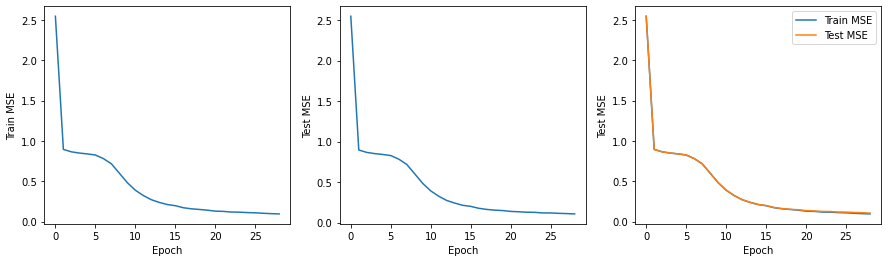

In [0]:
fig = plt.figure(figsize=(15, 4))
plt.subplot(1, 3, 1)
plt.plot(train_epoch_stats[:, 0], train_epoch_stats[:, 1])
plt.xlabel('Epoch')
plt.ylabel('Train MSE')
plt.subplot(1, 3, 2)
plt.plot(test_epoch_stats[:, 0], test_epoch_stats[:, 1])
plt.xlabel('Epoch')
plt.ylabel('Test MSE')
plt.subplot(1, 3, 3)
plt.plot(train_epoch_stats[:, 0], train_epoch_stats[:, 1], label='Train MSE')
plt.plot(test_epoch_stats[:, 0], test_epoch_stats[:, 1], label='Test MSE')
plt.legend(loc='best')
plt.xlabel('Epoch')
plt.ylabel('Test MSE')

### Error Plots

Text(0.5, 1.0, 'Error')

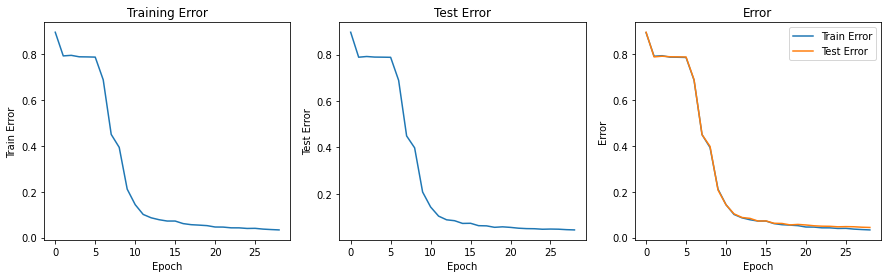

In [0]:
fig = plt.figure(figsize=(15, 4))
plt.subplot(1, 3, 1)
plt.plot(train_epoch_stats[:, 0], 1-train_epoch_stats[:, 2])
plt.xlabel('Epoch')
plt.ylabel('Train Error')
plt.title('Training Error')
plt.subplot(1, 3, 2)
plt.plot(test_epoch_stats[:, 0], 1-test_epoch_stats[:, 2])
plt.xlabel('Epoch')
plt.ylabel('Test Error')
plt.title('Test Error')
plt.subplot(1, 3, 3)
plt.plot(train_epoch_stats[:, 0], 1-train_epoch_stats[:, 2], label='Train Error')
plt.plot(test_epoch_stats[:, 0], 1-test_epoch_stats[:, 2], label='Test Error')
plt.legend(loc='best')
plt.xlabel('Epoch')
plt.ylabel('Error')
plt.title('Error')

### Accuracy Plots

Text(0.5, 1.0, 'Accuracy')

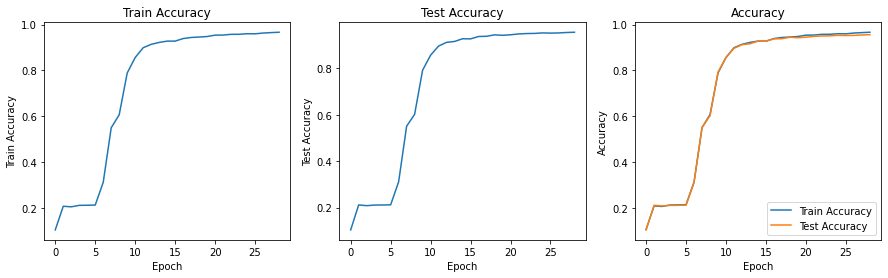

In [0]:
fig = plt.figure(figsize=(15, 4))
plt.subplot(1, 3, 1)
plt.plot(train_epoch_stats[:, 0], train_epoch_stats[:, 2])
plt.xlabel('Epoch')
plt.ylabel('Train Accuracy')
plt.title('Train Accuracy')
plt.subplot(1, 3, 2)
plt.plot(test_epoch_stats[:, 0], test_epoch_stats[:, 2])
plt.xlabel('Epoch')
plt.ylabel('Test Accuracy')
plt.title('Test Accuracy')
plt.subplot(1, 3, 3)
plt.plot(train_epoch_stats[:, 0], train_epoch_stats[:, 2], label='Train Accuracy')
plt.plot(test_epoch_stats[:, 0], test_epoch_stats[:, 2], label='Test Accuracy')
plt.legend(loc='best')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy')

## Pseudocode

while test_accuracy < 0.955:<br>
&emsp;for each training_example:<br>
&emsp;&emsp;for each layer $i$:<br>
&emsp;&emsp;&emsp;$v^i = {weights^i}^T \cdot activation^{i-1}$&emsp;{$activation^{i-1}$ for first layer is the train example}<br>
&emsp;&emsp;&emsp;$a^i = f^i(v^i)$<br>
&emsp;&emsp;&emsp;(store v and a in an array)<br>
&emsp;&emsp;for each layer $i$:<br>
&emsp;&emsp;&emsp;$\delta^i = (weights^{i+1} \cdot \delta^{i+1}) * {f^i}^{\prime}(v^i)$<br>
&emsp;&emsp;&emsp;$weights^i \leftarrow weights^i - \eta * (activation^{i-1} \cdot \delta^i)$<br>
&emsp;&emsp;&emsp;$bias^i \leftarrow bias^i - \eta * \delta^i$<br>
&emsp;mse = ${{1}\over{n}} \sum (d_i - y_i)^2$<br>
&emsp;test_accuracy = ${{num\_correct\_test}\over{num\_samples\_test}}$<br>
&emsp;if test_accuracy < test_accuracy_prev:<br>
&emsp;&emsp;$\eta \leftarrow \eta * decay\_factor$

### Where,<br>
$v^i \rightarrow$ Local field values of $i^{th}$ layer<br>
$w^i, b^i \rightarrow$ Weights and bias respectively for layer $i$<br>
$\delta^i \rightarrow$ Delta or error w.r.t layer $i$ (Derivative of cost function w.r.t to layer $i$)<br>
$f^i \rightarrow$ Activation function of layer $i$<br>
${f^i}^{\prime} \rightarrow$ Derivarive of activation function of layer $i$<br>
$a^i \rightarrow$ Activation of layer $i$<br>
$\eta \rightarrow$ Learning rate<br>
$\cdot \rightarrow$ Dot product<br>
$* \rightarrow$ Element-wise multiplication